In [21]:
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [22]:
# Cargar los keypoints, ángulos y las etiquetas
df = pd.read_csv(('csvFinal.csv'))

keypoints_columns = ['nose', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 
           'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 
           'right_knee', 'left_ankle', 'right_ankle', 'mid_shoulder', 'mid_hip']

angle_columns = [col for col in df.columns if 'angle' in col]

In [23]:
# Convertir keypoints y ángulos de cadenas a numpy arrays
for column in keypoints_columns:
    df[column] = df[column].apply(lambda x: np.array(ast.literal_eval(x)))

for column in angle_columns:
    df[column] = df[column].apply(lambda x: np.array(ast.literal_eval(x)))


In [24]:
# Normalizar los keypoints
scaler = StandardScaler()
for column in keypoints_columns:
    keypoints = np.stack(df[column].values)
    keypoints_normalized = scaler.fit_transform(keypoints)
    df[column] = [arr for arr in keypoints_normalized]

for column in keypoints_columns[:13]:
    df[column] = df[column].apply(lambda x: x[:2])


In [25]:
# Etiquetas
X_keypoints = np.array([df[keypoints_columns].iloc[i].values.tolist() for i in range(len(df))])
X_angles = np.array([df[angle_columns].iloc[i].values.tolist() for i in range(len(df))])
etiquetas = df['etiqueta'].values
label_encoder = LabelEncoder()
etiquetas_codificadas = label_encoder.fit_transform(etiquetas)
etiquetas_float = etiquetas_codificadas.astype(np.float32)

In [26]:

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [27]:
# Cargar las imágenes
dataset = ImageFolder(root='Dataset_Imagenes', transform=transform)
image_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Suponiendo que las imágenes y los keypoints están alineados
X_images = np.array([dataset[i][0].numpy() for i in range(len(dataset))])

In [28]:
# Verificar la cantidad de muestras
num_keypoints_samples = len(X_keypoints)
num_angle_samples = len(X_angles)
num_image_samples = len(X_images)
num_label_samples = len(etiquetas_codificadas)

print(f'Número de muestras de keypoints: {num_keypoints_samples}')
print(f'Número de muestras de ángulos: {num_angle_samples}')
print(f'Número de muestras de imágenes: {num_image_samples}')
print(f'Número de muestras de etiquetas: {num_label_samples}')


Número de muestras de keypoints: 1764
Número de muestras de ángulos: 1764
Número de muestras de imágenes: 1995
Número de muestras de etiquetas: 1764


In [29]:
# Alinear los datos si es necesario
min_samples = min(num_keypoints_samples, num_angle_samples, num_image_samples, num_label_samples)

X_keypoints = X_keypoints[:min_samples]
X_angles = X_angles[:min_samples]
X_images = X_images[:min_samples]
etiquetas_codificadas = etiquetas_codificadas[:min_samples]

In [30]:
# Verificar nuevamente la cantidad de muestras
print(f'Número de muestras después de alinear: {len(X_keypoints)}, {len(X_angles)}, {len(X_images)}, {len(etiquetas_codificadas)}')

Número de muestras después de alinear: 1764, 1764, 1764, 1764


In [31]:
# Preparar los datos
X_train_keypoints, X_test_keypoints, X_train_angles, X_test_angles, y_train, y_test = train_test_split(
    X_keypoints, X_angles, etiquetas_codificadas, test_size=0.2, random_state=42)
X_train_images, X_test_images, _, _ = train_test_split(X_images, etiquetas_codificadas, test_size=0.2, random_state=42)


In [32]:

# Transformar los datos a tensores
X_train_keypoints = torch.tensor(X_train_keypoints, dtype=torch.float32)
X_test_keypoints = torch.tensor(X_test_keypoints, dtype=torch.float32)
X_train_angles = torch.tensor(X_train_angles, dtype=torch.float32)
X_test_angles = torch.tensor(X_test_angles, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_train_images = torch.tensor(X_train_images, dtype=torch.float32)
X_test_images = torch.tensor(X_test_images, dtype=torch.float32)


In [33]:
# Definir el modelo de codificador de imágenes
class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten()
        )
        self.fc = nn.Linear(64 * 28 * 28, 128)  

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)
        return x


In [34]:
# Definir el modelo combinado
class CombinedModel(nn.Module):
    def __init__(self, num_keypoints, num_dimensions, num_angles, embed_dim, num_heads, ff_dim, num_classes):
        super(CombinedModel, self).__init__()
        self.keypoints_encoder = nn.Linear(num_keypoints * num_dimensions, embed_dim)
        self.angles_encoder = nn.Linear(num_angles, embed_dim)
        self.image_encoder = ImageEncoder()
        self.fc_combined = nn.Linear(embed_dim * 2 + 128, embed_dim)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=ff_dim),
            num_layers=1
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, keypoints, angles, images):
        keypoints_encoded = self.keypoints_encoder(keypoints.view(keypoints.size(0), -1))
        angles_encoded = self.angles_encoder(angles.view(angles.size(0), -1))
        images_encoded = self.image_encoder(images)
        combined = torch.cat((keypoints_encoded, angles_encoded, images_encoded), dim=1)
        combined = self.fc_combined(combined)
        combined = combined.unsqueeze(1).transpose(0, 1)
        output = self.transformer_encoder(combined)
        output = output.squeeze(0)
        output = self.fc(output)
        return output

In [35]:
# Inicializar el modelo
num_keypoints = len(keypoints_columns)
num_dimensions = 2
num_angles = len(angle_columns)
embed_dim = 32
num_heads = 4
ff_dim = 64
num_classes = len(label_encoder.classes_)

model = CombinedModel(num_keypoints, num_dimensions, num_angles, embed_dim, num_heads, ff_dim, num_classes)
print(model)


CombinedModel(
  (keypoints_encoder): Linear(in_features=30, out_features=32, bias=True)
  (angles_encoder): Linear(in_features=9, out_features=32, bias=True)
  (image_encoder): ImageEncoder(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Flatten(start_dim=1, end_dim=-1)
    )
    (fc): Linear(in_features=50176, out_features=128, bias=True)
  )
  (fc_combined): Linear(in_features=192, out_features=32, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layer

/home/waldos/anaconda3/envs/pytorch39/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [36]:
# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:

# Función para entrenar el modelo
def train_model(model, criterion, optimizer, X_train_keypoints, X_train_angles, X_train_images, y_train, num_epochs=10, batch_size=32):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, len(X_train_keypoints), batch_size):
            inputs_keypoints = X_train_keypoints[i:i+batch_size]
            inputs_angles = X_train_angles[i:i+batch_size]
            inputs_images = X_train_images[i:i+batch_size]
            labels = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs_keypoints, inputs_angles, inputs_images)
            loss = criterion(outputs, labels.long())  # Asegúrate de que las etiquetas sean de tipo long
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(X_train_keypoints)}')


In [41]:
print("Angulos:")
print(X_train_angles[0])
print("Keypoints:")
print(X_train_keypoints[0])
print("Imagenes:")  
print(X_train_images[0])

Angulos:
tensor([[126.1938],
        [263.9974],
        [167.4521],
        [ 91.0446],
        [164.7586],
        [267.2357],
        [188.3060],
        [ 85.5995],
        [243.7829]])
Keypoints:
tensor([[-0.2783, -1.6024],
        [-0.2803, -2.2388],
        [-0.3045, -2.0864],
        [-0.3045, -1.6989],
        [-0.3315, -2.2298],
        [-0.3517, -0.5010],
        [-0.3972, -1.1289],
        [-0.2164, -1.8875],
        [-0.3505, -2.0371],
        [-0.2207, -1.8062],
        [-0.3675, -1.7062],
        [-0.1551, -0.6982],
        [-0.7718, -2.7451],
        [-0.2932, -2.1839],
        [-0.2864, -1.9751]])
Imagenes:
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1008, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.0837],
         [-2.0837, -2.1008, -2.1008,  ..., -2.1008, -2.1008, -2.0837],

In [42]:
# Entrenar el modelo
train_model(model, criterion, optimizer, X_train_keypoints, X_train_angles, X_train_images, y_train, num_epochs=10)


Epoch [1/10], Loss: 0.061037935152871654
Epoch [2/10], Loss: 0.04707335923091475
Epoch [3/10], Loss: 0.03573178708511071
Epoch [4/10], Loss: 0.027016893620612686
Epoch [5/10], Loss: 0.019415209430232276
Epoch [6/10], Loss: 0.013556872624547493
Epoch [7/10], Loss: 0.008246166081102414
Epoch [8/10], Loss: 0.004993071363780788
Epoch [9/10], Loss: 0.002835128710471215
Epoch [10/10], Loss: 0.0017749710017742628


Test Accuracy: 79.89%


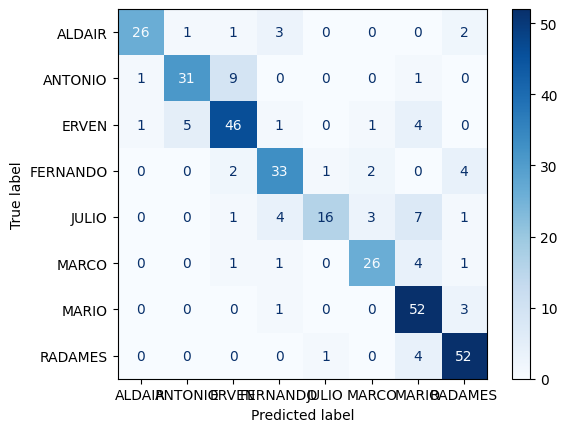

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Evaluar el modelo
model.eval()
with torch.no_grad():
    outputs = model(X_test_keypoints, X_test_angles, X_test_images)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [44]:
# Guardar el modelo
torch.save(model.state_dict(), 'modelo_Transformers.pth')